# Building CNN From Scratch With Keras For Cancer Detection
***By Kris Smith***

## Import Libraries

In [63]:
import numpy as np, pandas as pd
import os
import cv2
from PIL import Image ## For working with images
from glob import glob 
import matplotlib.pyplot as plt
%matplotlib inline
print(os.listdir("../input/histopathologic-cancer-detection"))
#############################################################
from keras.callbacks import *


from keras.models import *
from keras.layers.normalization import *
from keras.layers.convolutional import *
from keras.layers.core import *



import os, cv2
from scipy import stats

from tqdm import tqdm_notebook,trange

from time import time

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

from keras.callbacks import TensorBoard

# import the necessary packages
from keras.models import Sequential
# from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


---

# EDA

## Load Data

In [64]:
print(f'Total Number of Samples in Training Data = {len(os.listdir("../input/histopathologic-cancer-detection/train"))}')
print(f'Total Number of Samples in Test Data = {len(os.listdir("../input/histopathologic-cancer-detection/test"))}')

Total Number of Samples in Training Data = 220025
Total Number of Samples in Test Data = 57458


In [65]:
path = "../input/histopathologic-cancer-detection/"
train_path = path + 'train/'
test_path = path + 'test/'

### Read data into pandas frames ###
## Load training and testing file names into frames
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))}) 

## Isolate the id from file names and store as id features in seperate column
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) 

## Read in training labels
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

## Add Labels to training data 
df = df.merge(labels, on = "id") # merge labels and filepaths
df.sample(7)

,path,id,label
111460,../input/histopathologic-cancer-detection/trai...,21e4398acd352a3d48763fad238e39416c71b9e6,1
65078,../input/histopathologic-cancer-detection/trai...,37cc423036d55253c5e1210e24740b83f103b6f4,0
146588,../input/histopathologic-cancer-detection/trai...,46e93aba5bc604a277bd7d06cce4590f02cf734c,0
55271,../input/histopathologic-cancer-detection/trai...,629474f6a3851c594b243f4afbd62d7149a15643,0
108002,../input/histopathologic-cancer-detection/trai...,a1d44c92980b91a15e1846c4d01e0e8e35a60479,0
141933,../input/histopathologic-cancer-detection/trai...,d0f1244320ffd74e7069a37d9a460a55294ac88f,0
91381,../input/histopathologic-cancer-detection/trai...,d9c651d62b4d520957d826e1bdf9bd3044cb4c2e,0


## Lets Inspect Distribution Among The Classes in Training Data

<AxesSubplot: title={'center': 'Class Distribution in Training Data'}>

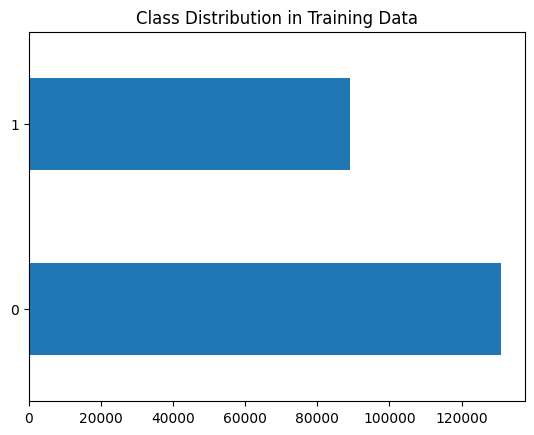

In [66]:
labels['label'].value_counts().plot(kind='barh', title='Class Distribution in Training Data')

## Inspect Some Samples From Both Positive and Negative Classes

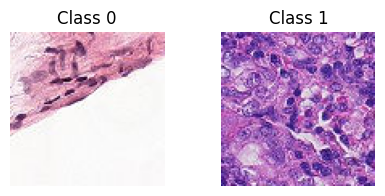

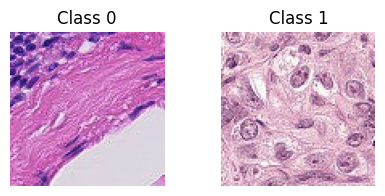

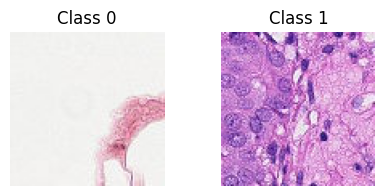

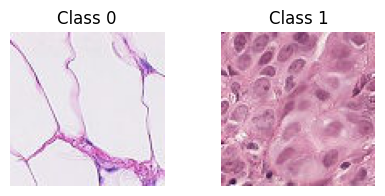

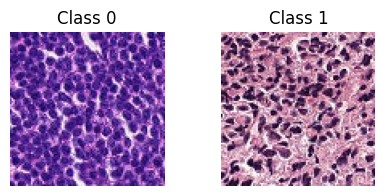

In [67]:
## Filter dataframe to get a subset of each class
class0 = df[df['label'] == 0]
class1 = df[df['label'] == 1]

for image in range(5):
    ## Select a random sample from each class
    sample0 = class0.sample(1)
    sample1 = class1.sample(1)

    ## Open image files and plot
    img_path0 = sample0['path'].values[0]
    img_path1 = sample1['path'].values[0]

    img0 = Image.open(img_path0)
    img1 = Image.open(img_path1)

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))

    ax[0].imshow(img0)
    ax[0].set_title('Class 0')
    ax[0].axis('off')

    ax[1].imshow(img1)
    ax[1].set_title('Class 1')
    ax[1].axis('off')

    plt.show()

*** Inspecting these images I am realizing that I am not a medical professional and therefore I can see no obvious differences between the positive and negative class images. Therefore I will be relying on the labels and the model to distinguish between the two.***

---
# Training

## Split Training Data

In [68]:

# df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
# df['label'] = df['label'].astype(str)
# df = df.sample(1000)

In [ ]:
# !pip install git+https://github.com/keras-team/keras-preprocessing.git
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

df['label'] = df['label'].astype(str)
# df = df.sample(640)

def append_ext(ID):
    return(ID+".tif")


df["id"] = df["id"].apply(append_ext)



train_datagen = ImageDataGenerator(
       # horizontal_flip=True,
       #vertical_flip=True,
       #brightness_range=[0.5, 1.5],
       #fill_mode='reflect',                               
        #rotation_range=15,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2
        validation_split=0.15
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '../input/histopathologic-cancer-detection/train'
valid_path = '../input/histopathologic-cancer-detection/train'

train_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=train_path,
                x_col = 'id',
                y_col = 'label',
#                 has_ext=True,
                subset='training',
                target_size=(96, 96),
                batch_size=64,
                class_mode='binary'
                )

validation_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=valid_path,
                x_col = 'id',
                y_col = 'label',
#                 has_ext=True,
                subset='validation', # This is the trick to properly separate train and validation dataset
                target_size=(96, 96),
                batch_size=64,
                shuffle=False,
                class_mode='binary'
                )

## Building Model Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size


history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID)

In [ ]:
model.evaluate_generator(generator=validation_generator)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()